<a href="https://colab.research.google.com/github/Bengiawilliam/solubility-prediction-using-ChemBERTa/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Molecular Solubility with **ChemBERTa**

# This notebook demonstrates how to fine-tune a ChemBERTa model to predict the solubility of molecules given their SMILES strings.
# We will use the `transformers` library from Hugging Face and PyTorch.

# ## 1. Install Necessary Libraries

In [1]:
!pip install transformers torch scikit-learn pandas numpy matplotlib

# ## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import matplotlib.pyplot as plt

# ## 3. Load and Inspect Data
#
# We'll load the `curated-solubility-dataset.csv` file. Make sure this file is in the same directory as your notebook, or provide the correct path.

In [2]:
df = pd.read_csv('curated-solubility-dataset.csv')

In [3]:
print("Dataset head:")
print(df.head())
print("\nDataset info:")
df.info()


Dataset head:
    ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0   

# ## 4. Data Preprocessing

# We need to:
# 1.  Select relevant columns (SMILES and Solubility).
# 2.  Handle any missing values (though our initial check showed none for these columns).
# 3.  Split the data into training and validation sets.


In [4]:
df_processed = df[['SMILES', 'Solubility']].copy()

In [5]:
df_processed.dropna(subset=['SMILES', 'Solubility'], inplace=True)

In [6]:
# For demonstration purposes, let's use a smaller subset of the data to speed up training.
# You can comment this out to use the full dataset.
# df_processed = df_processed.sample(n=2000, random_state=42)
# print(f"\nUsing a subset of {len(df_processed)} samples for faster processing.")


# Split data
train_df, val_df = train_test_split(df_processed, test_size=0.2, random_state=42)

In [7]:
print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")



Training set size: 7985
Validation set size: 1997


# ## 5. ChemBERTa Tokenizer and Model Setup

# We'll use a pre-trained ChemBERTa model. `seyonec/ChemBERTa-zinc-base-v1` is a common choice.

In [8]:
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1" # You can try others like "DeepChem/ChemBERTa-77M-MTR"

In [9]:
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Please ensure you have an internet connection and the model name is correct.")
    # Fallback or stop execution if tokenizer can't be loaded.
    # For now, let's assume it loads. If not, the subsequent cells will fail.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

# ## 6. Create PyTorch Datasets


# We need a custom Dataset class to handle tokenization.

In [10]:
class SolubilityDataset(Dataset):
    def __init__(self, smiles_list, targets, tokenizer, max_length=128):
        self.smiles_list = smiles_list
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = str(self.smiles_list[idx])
        target = float(self.targets[idx])

        encoding = self.tokenizer.encode_plus(
            smiles,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Create datasets
if 'tokenizer' in globals(): # Proceed only if tokenizer was loaded
    train_dataset = SolubilityDataset(
        train_df['SMILES'].tolist(),
        train_df['Solubility'].tolist(),
        tokenizer
    )
    val_dataset = SolubilityDataset(
        val_df['SMILES'].tolist(),
        val_df['Solubility'].tolist(),
        tokenizer
    )
else:
    print("Tokenizer not loaded. Cannot create datasets.")


# ## 7. Define the Regression Model

# We'll add a regression head (a simple linear layer) on top of the ChemBERTa base model.

In [11]:
class ChemBERTaRegressor(torch.nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super(ChemBERTaRegressor, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        # The regressor will take the [CLS] token's embedding as input
        self.regressor = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the embedding of the [CLS] token (pooler_output)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

if 'tokenizer' in globals(): # Proceed only if tokenizer was loaded
    model = ChemBERTaRegressor()
else:
    print("Tokenizer not loaded. Cannot create model.")


pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

# ## 8. Training Setup

# Define hyperparameters, DataLoaders, optimizer, and scheduler.

In [12]:
BATCH_SIZE = 16 # Adjust based on your GPU memory. Reduce if you get OOM errors.
EPOCHS = 5      # Increase for better performance, but longer training.
LEARNING_RATE = 2e-5
MAX_LEN = 128   # Max length for SMILES tokenization

if 'train_dataset' in globals() and 'val_dataset' in globals(): # Proceed if datasets exist
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
else:
    print("Datasets not created. Cannot create DataLoaders.")

# Optimizer and Scheduler
if 'model' in globals(): # Proceed if model exists
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0, # Default, you can adjust
        num_training_steps=total_steps
    )
else:
    print("Model not created. Cannot setup optimizer/scheduler.")


# Loss function
loss_fn = torch.nn.MSELoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if 'model' in globals():
    model.to(device)
print(f"Using device: {device}")



Using device: cuda


# ## 9. Training and Validation Loop

In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.squeeze(), targets)

        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.squeeze(), targets)
            total_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.squeeze().cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)
    return avg_loss, rmse, r2, all_targets, all_predictions


# ### Start Training

# **Note:** This part can take a while, especially without a GPU or with a large dataset/many epochs.

In [14]:
history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_r2': []}

if 'model' in globals() and 'train_dataloader' in globals() and 'val_dataloader' in globals():
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print("-" * 10)

        train_loss = train_epoch(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            device,
            scheduler
        )
        print(f"Train Loss: {train_loss:.4f}")
        history['train_loss'].append(train_loss)

        val_loss, val_rmse, val_r2, _, _ = eval_model(
            model,
            val_dataloader,
            loss_fn,
            device
        )
        print(f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val R2: {val_r2:.4f}")
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_r2'].append(val_r2)
    print("Training complete!")
else:
    print("Skipping training due to missing model or dataloaders.")


Epoch 1/5
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 2.6026
Val Loss: 1.6106, Val RMSE: 1.2693, Val R2: 0.7030
Epoch 2/5
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 1.4589
Val Loss: 1.3446, Val RMSE: 1.1597, Val R2: 0.7521
Epoch 3/5
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 1.1412
Val Loss: 1.2401, Val RMSE: 1.1137, Val R2: 0.7714
Epoch 4/5
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 0.9243
Val Loss: 1.2158, Val RMSE: 1.1026, Val R2: 0.7759
Epoch 5/5
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss: 0.7977
Val Loss: 1.2139, Val RMSE: 1.1020, Val R2: 0.7762
Training complete!


# ## 10. Plot Training History

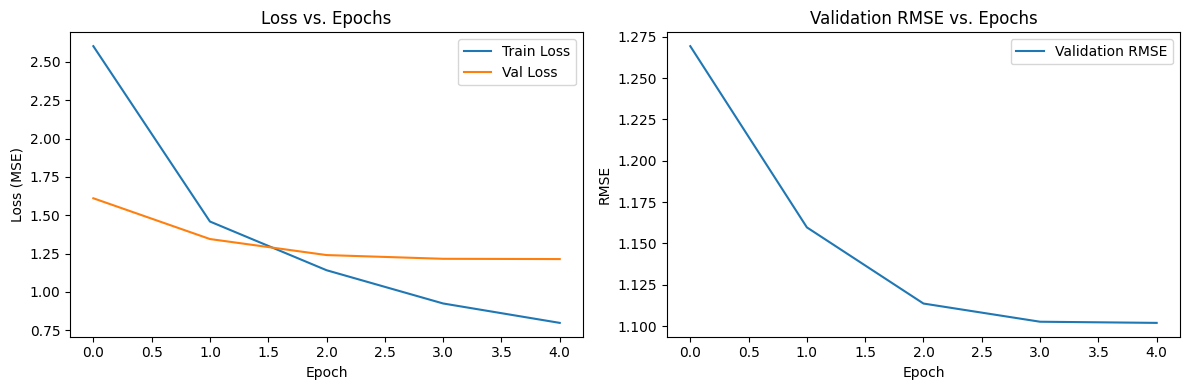

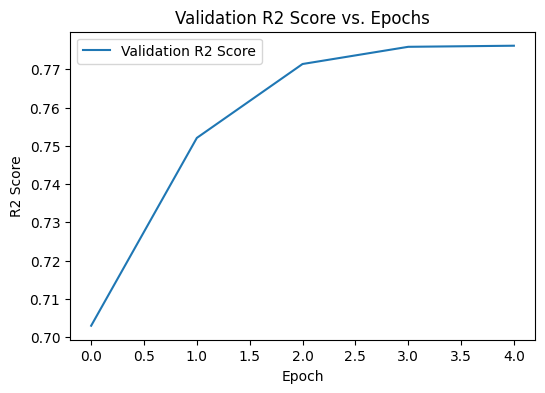

In [15]:
if history['train_loss']: # Check if training was run
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Loss vs. Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_rmse'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('Validation RMSE vs. Epochs')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(history['val_r2'], label='Validation R2 Score')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.title('Validation R2 Score vs. Epochs')
    plt.show()



# ## 11. Evaluate on the Validation Set (Final)

# Let's get the final predictions and plot them against actual values.


Final Validation Metrics:
  MSE: 1.2139
  RMSE: 1.1020
  R2 Score: 0.7762


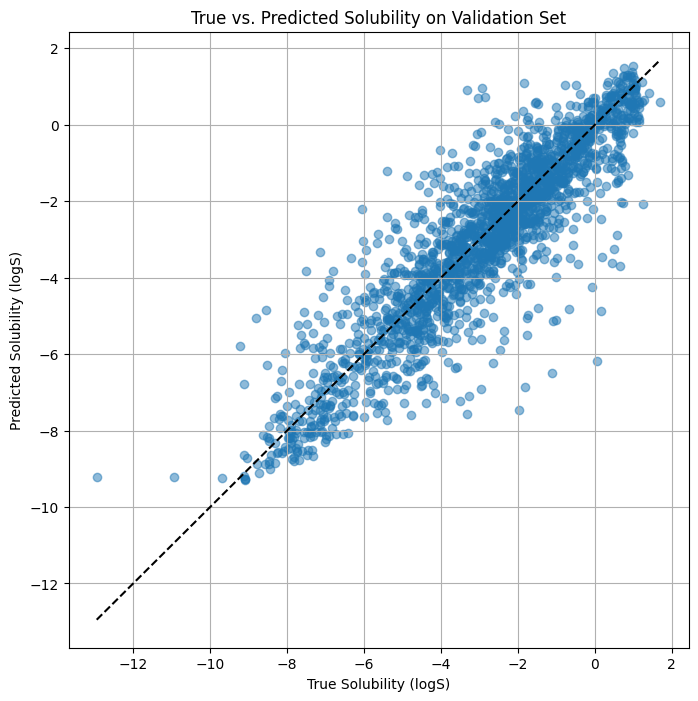

In [16]:
if 'model' in globals() and 'val_dataloader' in globals():
    avg_loss, rmse, r2, true_values, predictions = eval_model(model, val_dataloader, loss_fn, device)
    print(f"\nFinal Validation Metrics:")
    print(f"  MSE: {avg_loss:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")

    # Scatter plot of True vs. Predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.xlabel("True Solubility (logS)")
    plt.ylabel("Predicted Solubility (logS)")
    plt.title("True vs. Predicted Solubility on Validation Set")
    # Add a line y=x for reference
    min_val = min(min(true_values), min(predictions))
    max_val = max(max(true_values), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.grid(True)
    plt.show()
else:
    print("Skipping final evaluation due to missing model or dataloaders.")



# ## 12. Create a Prediction Function

# This function will take a SMILES string and return the predicted solubility.

In [17]:
def predict_solubility(smiles_string, model, tokenizer, device, max_length=MAX_LEN):
    """
    Predicts solubility for a single SMILES string.
    """
    if 'model' not in globals() or 'tokenizer' not in globals():
        print("Model or tokenizer not available for prediction.")
        return None

    model.eval() # Ensure model is in evaluation mode

    encoding = tokenizer.encode_plus(
        smiles_string,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        prediction = model(input_ids=input_ids, attention_mask=attention_mask)

    return prediction.item()


# ### Test the Prediction Function

In [18]:
if 'model' in globals() and 'tokenizer' in globals():
    # Example SMILES strings (you can replace these)
    example_smiles_1 = "CCO"  # Ethanol
    example_smiles_2 = "c1ccccc1C(=O)O"  # Benzoic acid
    example_smiles_3 = "CC(=O)Oc1ccccc1C(=O)OH" # Aspirin (from our dummy data example)

    predicted_sol_1 = predict_solubility(example_smiles_1, model, tokenizer, device)
    predicted_sol_2 = predict_solubility(example_smiles_2, model, tokenizer, device)
    predicted_sol_3 = predict_solubility(example_smiles_3, model, tokenizer, device)

    print(f"\nPredicted solubility for {example_smiles_1}: {predicted_sol_1:.4f} logS" if predicted_sol_1 is not None else "")
    print(f"Predicted solubility for {example_smiles_2}: {predicted_sol_2:.4f} logS" if predicted_sol_2 is not None else "")
    print(f"Predicted solubility for {example_smiles_3}: {predicted_sol_3:.4f} logS" if predicted_sol_3 is not None else "")

    # You can also try a SMILES from your validation set to compare
    if len(val_df) > 0:
        sample_val_smiles = val_df.iloc[0]['SMILES']
        sample_val_actual_sol = val_df.iloc[0]['Solubility']
        predicted_sol_val = predict_solubility(sample_val_smiles, model, tokenizer, device)
        print(f"\nExample from validation set:")
        print(f"SMILES: {sample_val_smiles}")
        print(f"Actual Solubility: {sample_val_actual_sol:.4f} logS")
        print(f"Predicted Solubility: {predicted_sol_val:.4f} logS" if predicted_sol_val is not None else "")
else:
    print("Cannot test prediction function as model/tokenizer is not loaded/trained.")



Predicted solubility for CCO: 0.9371 logS
Predicted solubility for c1ccccc1C(=O)O: -1.5086 logS
Predicted solubility for CC(=O)Oc1ccccc1C(=O)OH: -2.7316 logS

Example from validation set:
SMILES: CCc1ccc2C(=O)c3ccccc3C(=O)c2c1
Actual Solubility: -5.9842 logS
Predicted Solubility: -6.2416 logS


# ## 13. Save the Fine-tuned Model (Optional)

# Define path to save the model

In [19]:
OUTPUT_MODEL_PATH = "./chemberta_solubility_predictor"

In [20]:
if 'model' in globals() and history['train_loss']: # Only save if trained
   # Create directory if it doesn't exist
   import os
   if not os.path.exists(OUTPUT_MODEL_PATH):
       os.makedirs(OUTPUT_MODEL_PATH)

   # Save the model's state_dict
   torch.save(model.state_dict(), os.path.join(OUTPUT_MODEL_PATH, "pytorch_model.bin"))
   # Save the tokenizer
   tokenizer.save_pretrained(OUTPUT_MODEL_PATH)
   print(f"Model and tokenizer saved to {OUTPUT_MODEL_PATH}")

   # To load the model later:
   # model_loaded = ChemBERTaRegressor() # Initialize with the correct class
   # model_loaded.load_state_dict(torch.load(os.path.join(OUTPUT_MODEL_PATH, "pytorch_model.bin")))
   # tokenizer_loaded = AutoTokenizer.from_pretrained(OUTPUT_MODEL_PATH)
   # model_loaded.to(device)
   # print("Model reloaded successfully.")

else:
   print("Model not trained or available, skipping save.")


Model and tokenizer saved to ./chemberta_solubility_predictor


# ---
# End of Notebook. You can now use the `predict_solubility` function with your trained model.
# Remember that the quality of predictions depends heavily on the training data, model architecture, hyperparameters, and training duration.
# For production use, more extensive training, hyperparameter tuning, and cross-validation are recommended.
# ---

# **# ## Predict for a Custom SMILES Input**

skip to next section if you trained your model in the current evironment

In [ ]:

# Your custom SMILES string
#custom_smiles = "Cc1ccccc1N"  # Example: N-methylaniline

# If you just trained, use 'model', 'tokenizer', and 'device'
# If you loaded them, use 'loaded_model', 'loaded_tokenizer', and 'current_device' (or whatever you named them)

# Make sure to replace 'model', 'tokenizer', 'device' with your actual variable names if they are different
# (e.g., if you loaded them as loaded_model, loaded_tokenizer, current_device)

# Assuming you just trained, the variables would be:
# model_to_predict_with = model
# tokenizer_for_prediction = tokenizer
# device_for_prediction = device
# MAX_LEN_for_prediction = MAX_LEN # Ensure this is the same MAX_LEN used during training/dataset creation

# If you loaded the model, they would be:
# model_to_predict_with = loaded_model
# tokenizer_for_prediction = loaded_tokenizer
# device_for_prediction = current_device
# MAX_LEN_for_prediction = MAX_LEN # Or the MAX_LEN you defined when loading



if you just finished training in the same session:

In [22]:
custom_smiles = "Cc1ccccc1N"  # Example: N-methylaniline
if 'model' in locals() and 'tokenizer' in locals() and 'device' in locals() and 'MAX_LEN' in locals():
    predicted_value = predict_solubility(
        custom_smiles,
        model,          # Your trained model object
        tokenizer,      # Your tokenizer object
        device,         # The device your model is on ('cuda' or 'cpu')
        max_length=MAX_LEN # The max_length used during training
    )

    if predicted_value is not None:
        print(f"The predicted solubility (logS) for '{custom_smiles}' is: {predicted_value:.4f}")
    else:
        print(f"Could not predict solubility for '{custom_smiles}'. Check for errors.")
else:
    print("Model, tokenizer, device or MAX_LEN not found. Make sure they are loaded/defined.")

# Example with another SMILES
another_custom_smiles = "O=C(O)c1ccccc1OC(=O)C" # Aspirin
if 'model' in locals() and 'tokenizer' in locals() and 'device' in locals() and 'MAX_LEN' in locals():
    predicted_value_aspirin = predict_solubility(
        another_custom_smiles,
        model, tokenizer, device, max_length=MAX_LEN
    )
    if predicted_value_aspirin is not None:
        print(f"The predicted solubility (logS) for '{another_custom_smiles}' is: {predicted_value_aspirin:.4f}")

The predicted solubility (logS) for 'Cc1ccccc1N' is: -1.0585
The predicted solubility (logS) for 'O=C(O)c1ccccc1OC(=O)C' is: -2.7206


**FOR SAVING THE MODEL**

In [23]:
OUTPUT_MODEL_PATH = "./chemberta_solubility_predictor"

if 'model' in globals() and history['train_loss']: # Only save if trained
   # Create directory if it doesn't exist
   import os
   if not os.path.exists(OUTPUT_MODEL_PATH):
       os.makedirs(OUTPUT_MODEL_PATH)

   # Save the model's state_dict
   torch.save(model.state_dict(), os.path.join(OUTPUT_MODEL_PATH, "pytorch_model.bin"))
   # Save the tokenizer
   tokenizer.save_pretrained(OUTPUT_MODEL_PATH)
   print(f"Model and tokenizer saved to {OUTPUT_MODEL_PATH}")

Model and tokenizer saved to ./chemberta_solubility_predictor


for loading the model

In [24]:
model_loaded = ChemBERTaRegressor() # Initialize with the correct class
model_loaded.load_state_dict(torch.load(os.path.join(OUTPUT_MODEL_PATH, "pytorch_model.bin")))
tokenizer_loaded = AutoTokenizer.from_pretrained(OUTPUT_MODEL_PATH)
model_loaded.to(device)
print("Model reloaded successfully.")

Model reloaded successfully.


In [25]:
if 'model' in locals() and 'tokenizer' in locals() and 'device' in locals() and 'MAX_LEN' in locals():
    predicted_value = predict_solubility(
        custom_smiles,
        model_loaded,          # Your trained model object
        tokenizer,      # Your tokenizer object
        device,         # The device your model is on ('cuda' or 'cpu')
        max_length=MAX_LEN # The max_length used during training
    )

    if predicted_value is not None:
        print(f"The predicted solubility (logS) for '{custom_smiles}' is: {predicted_value:.4f}")
    else:
        print(f"Could not predict solubility for '{custom_smiles}'. Check for errors.")
else:
    print("Model, tokenizer, device or MAX_LEN not found. Make sure they are loaded/defined.")


The predicted solubility (logS) for 'Cc1ccccc1N' is: -1.0585
